In [1]:
import os 
##provides functions for interacting with the OS
import glob 
##used to similarly find, locate & search for all of the files that are present in a system
import numpy as np  
##computation & processing of single dimensional and multi-dimensional arrays 
import matplotlib.pyplot as plt 
##used to create static, animated & interactive visualizations
import tensorflow as tf 
## Here, we have used TensorFlow platform for model tracking, 
## performance monitoring, and model retraining
from tensorflow.keras.preprocessing.image import load_img, img_to_array
##keras is an approachable, highly-productive interface for solving machine learning problems
## load_img - Loads an image into PIL (Python Imaging Library) format
## img_to_array - Converts a PIL Image instance to a Numpy array
from tensorflow.image import resize_with_pad
## Resizes and pads an image to a target width and height
from tensorflow.keras import Sequential
## A Sequential model is appropriate for a plain stack of layers 
## where each layer has exactly one input tensor and one output tensor
from tensorflow.keras.optimizers import Adam
## Adam is a replacement optimization algorithm for stochastic gradient descent 
## for training deep learning models
from tensorflow.keras.layers import Conv2D, Dropout, LeakyReLU, MaxPooling2D, UpSampling2D
"""Conv2D - spatial convolution over images
Dropout - The Dropout layer randomly sets input units to 0 with a frequency of rate 
at each step during training time, which helps prevent overfitting"""

'Conv2D - spatial convolution over images\nDropout - The Dropout layer randomly sets input units to 0 with a frequency of rate \nat each step during training time, which helps prevent overfitting'

In [2]:
BASE_IMAGE_PATH = 'Images'
BASE_LABELS_PATH = 'Labels'
TARGET_IMAGE_SIZE = (256, 256)
LEARNING_RATE = 0.0001
##The learning rate is a hyperparameter that controls how much to change the  
## model in response to the estimated error each time the model weights are updated
BATCH_SIZE = 16
## batch_size - Number of samples per gradient update
EPOCHS = 50
##Number of samples per gradient update
VAL_SPLIT = 0.2

In [3]:
image_data = []
image_labels = []

image_count = len(os.listdir(BASE_IMAGE_PATH))

for i in range(1, image_count + 1):
    img = load_img(os.path.join(BASE_IMAGE_PATH, str(i) + '.jpeg'))
    img = img_to_array(img, dtype = 'uint8')
    image_data.append(img)
    
    label_mask = np.zeros((*img.shape[:2], 1))
    
    with open(os.path.join(BASE_LABELS_PATH, str(i) + '.txt'), 'r') as label_file:
        l_count = int(label_file.readline())
        
        for i in range(l_count):
            box = list(map(int, label_file.readline().split()))
            label_mask[box[1]:box[3], box[0]:box[2]] = 1.0
        
    image_labels.append(label_mask)

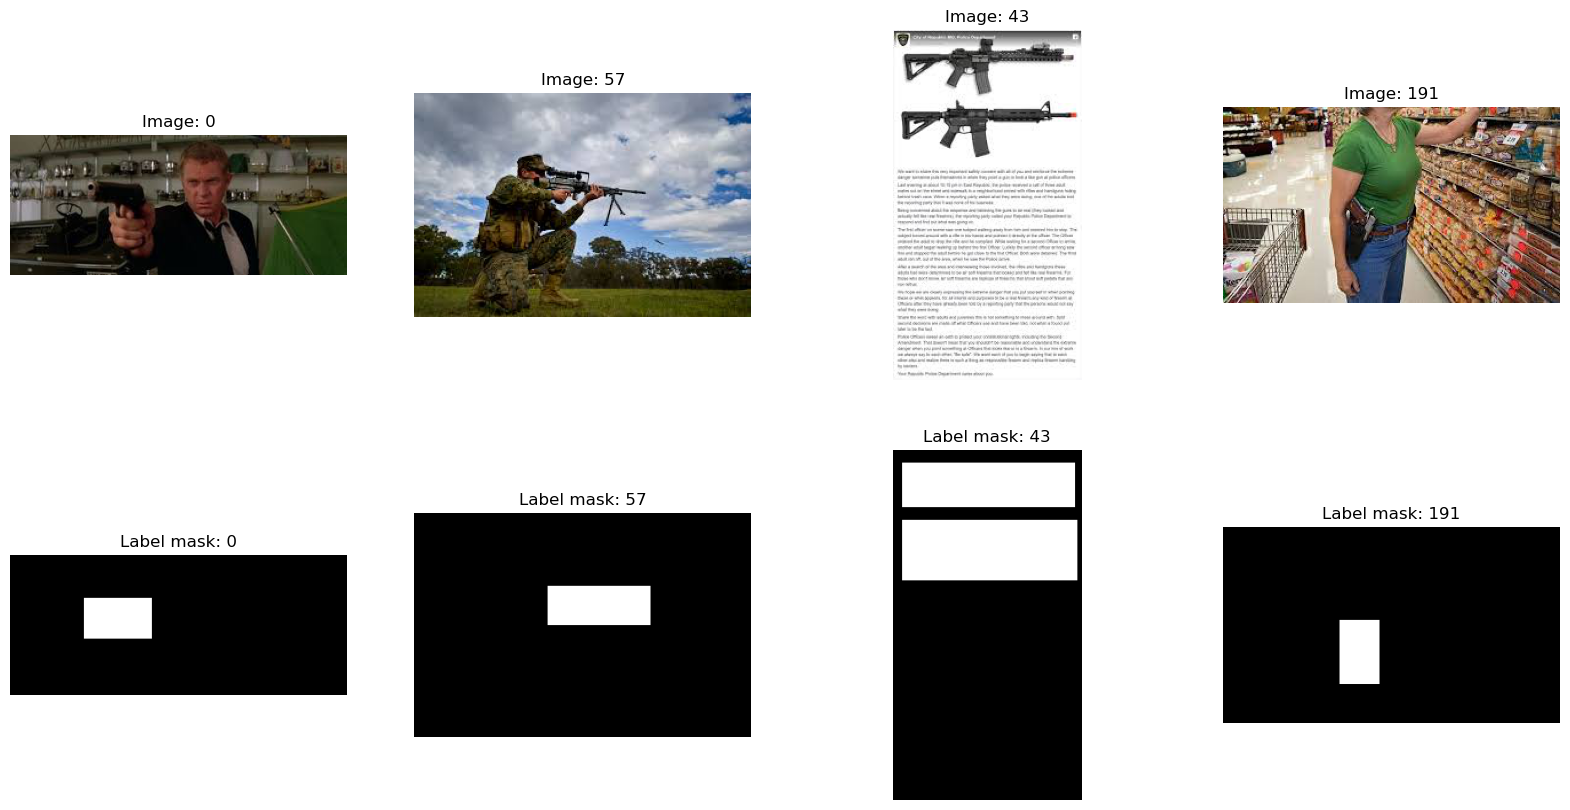

In [4]:
plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))

for i, img_index in enumerate(np.random.randint(0, image_count, size = 4)):
    plt.subplot(2, 4, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Image: {img_index}')
    plt.imshow(image_data[img_index])
    
    plt.subplot(2, 4, i + 5)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Label mask: {img_index}')
    plt.imshow(image_labels[img_index], cmap = 'gray')
plt.show()

In [5]:
for i in range(image_count):
    image_data[i] = resize_with_pad(image_data[i], *TARGET_IMAGE_SIZE).numpy() / 255.0
    image_labels[i] = resize_with_pad(image_labels[i], *TARGET_IMAGE_SIZE).numpy()

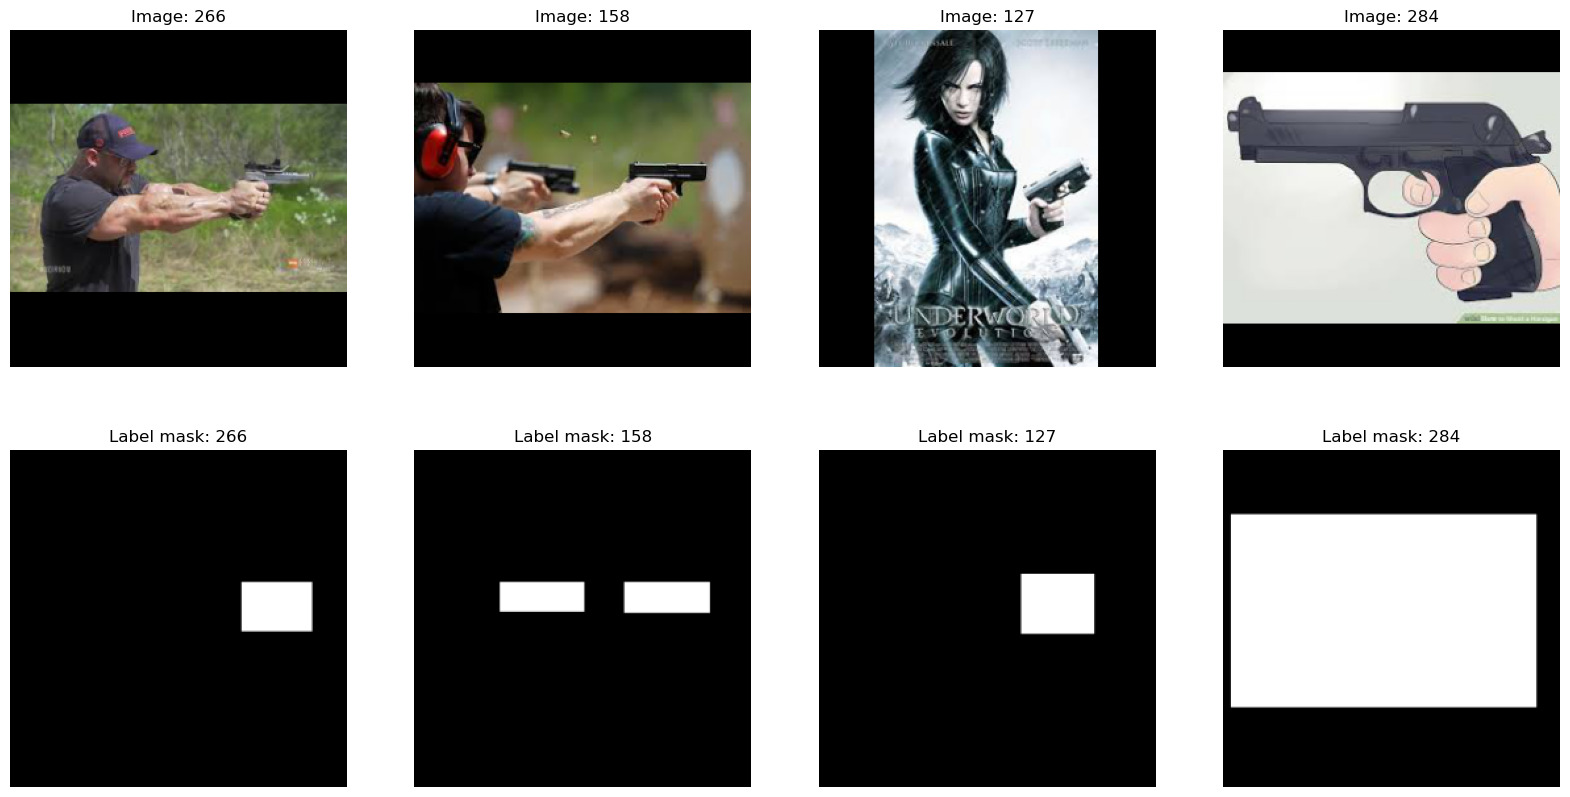

In [6]:
plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))

for i, img_index in enumerate(np.random.randint(0, image_count, size = 4)):
    plt.subplot(2, 4, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Image: {img_index}')
    plt.imshow(image_data[img_index])
    
    plt.subplot(2, 4, i + 5)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Label mask: {img_index}')
    plt.imshow(image_labels[img_index], cmap = 'gray')
plt.show()

In [7]:
image_data = np.array(image_data)
image_labels = np.array(image_labels)

In [8]:
def weighted_bce(y_true, y_pred):
    LOSS_WEIGHT = 8
    loss_ones = LOSS_WEIGHT * y_true * tf.math.log(y_pred + 1e-7)
    loss_zeros = (1 - y_true) * tf.math.log(1 - y_pred + 1e-7)
    loss = - loss_ones - loss_zeros
    return tf.reduce_mean(loss)

In [9]:
model = Sequential([
    Conv2D(32, 5, padding = 'same', input_shape = (*TARGET_IMAGE_SIZE, 3), activation = LeakyReLU()),
    MaxPooling2D(),

    Conv2D(64, 4, padding = 'same', activation = LeakyReLU()),
    MaxPooling2D(),
    
    Conv2D(128, 3, padding = 'same', activation = LeakyReLU()),
    Dropout(0.1),
    
    UpSampling2D(),
    Conv2D(64, 4, padding = 'same', activation = LeakyReLU()),

    UpSampling2D(),
    Conv2D(32, 5, padding = 'same', activation = LeakyReLU()),

    Dropout(0.1),
    Conv2D(1, 3, padding = 'same', activation = 'sigmoid'),
])

##Activation functions allow for ML models to solve nonlinear problems

model.compile(optimizer = Adam(LEARNING_RATE), loss = weighted_bce)

model.summary()

##Param is a library for handling all the user-modifiable parameters, arguments, 
## and attributes that control your code

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 dropout (Dropout)           (None, 64, 64, 128)       0

In [ ]:
%%time

history = model.fit(image_data, image_labels, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = VAL_SPLIT, verbose = 1)

Epoch 1/50
17/17 [==============================] - 278s 16s/step - loss: 1.1131 - val_loss: 1.0792
Epoch 2/50
17/17 [==============================] - 276s 16s/step - loss: 1.1046 - val_loss: 1.0674
Epoch 3/50
17/17 [==============================] - 276s 16s/step - loss: 1.0810 - val_loss: 1.0257
Epoch 4/50
17/17 [==============================] - 275s 16s/step - loss: 1.0035 - val_loss: 0.8852
Epoch 5/50
17/17 [==============================] - 281s 17s/step - loss: 0.8860 - val_loss: 0.8036
Epoch 6/50
 7/17 [===========>..................] - ETA: 3:17 - loss: 0.7861

In [ ]:
plt.subplots(nrows = 3, ncols = 4, figsize = (20, 10))

indices_to_predict = np.random.randint(0, image_count, size = 4)

for i, img_index in enumerate(indices_to_predict):
    preds = model.predict(image_data[indices_to_predict])
    
    masked_images = preds * image_data[indices_to_predict]
    
    plt.subplot(3, 4, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Image: {img_index}')
    plt.imshow(image_data[img_index])
    
    plt.subplot(3, 4, i + 5)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Predicted mask: {img_index}')
    plt.imshow(preds[i], cmap = 'gray')
    
    plt.subplot(3, 4, i + 9)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Masked image: {img_index}')
    plt.imshow(masked_images[i])
plt.show()

# Improvements required
- Image augmentation
- Custom loss function to give more weightage to the value 1 in the target - **Done**